In [10]:
### Function Imports
from OptionsFunctions import import_fx_data, plot_forex, daily_returns

In [11]:
### Call Function to Load in Rate Data (Get Spot Price S_0)
all_forex_pairs = [
        'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'AUDUSD=X', 'NZDUSD=X',
        'USDCAD=X', 'EURGBP=X', 'EURJPY=X', 'EURCHF=X', 'EURAUD=X', 'EURNZD=X',
        'EURCAD=X', 'GBPAUD=X', 'GBPJPY=X', 'GBPCHF=X', 'AUDJPY=X', 'AUDCHF=X',
        'AUDNZD=X', 'NZDJPY=X', 'NZDCHF=X', 'CADJPY=X', 'CADCHF=X', 'CHFJPY=X'
    ]
pair = ['USDEUR=X']
start_date = '2019-01-01'
forex_data = import_fx_data(pair, start_date)
# Get the Spot Price (Most recent FX rate value)
S_0 = forex_data[pair].iloc[-1]
print('The Spot Price is:', round(S_0, 4))


[*********************100%%**********************]  1 of 1 completed

The Spot Price is: USDEUR=X    0.9329
Name: 1430, dtype: float64


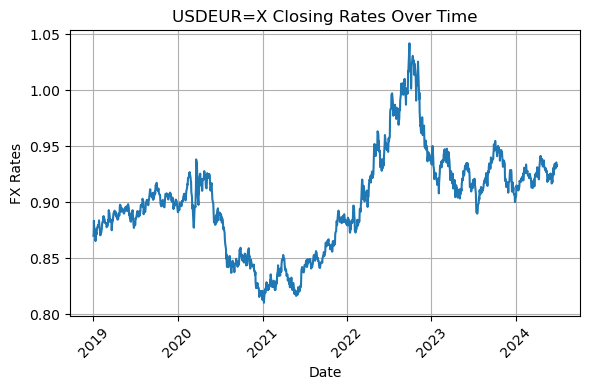

In [12]:
### Call Function to Plot FX Data
plot_forex(forex_data, pair)